# Simulations modèle ICSV

In [1]:
import vocal_tract_rho_V as vc
from body_vocal_tract import *
from terminal_impedance import *

import pyphs as phs
import sympy as sy
import numpy as np
import os
from utils import signal_generator
from utils import functions
from utils.glottal_signal_generator import glottal_signal
from utils.signal_generator import simple_mouth_opening
from utils.signal_generator import mouth_opening_and_glottal
from utils.timer import Timer as Timer
import datetime
import pickle
import sympy as sy
import matplotlib.pyplot as plt
from scipy.io.wavfile import write as wavWrite
import h5py
sy.init_printing()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

PPTY_PHY_PARAMS = {"positive": True, "real" : True }                            
PPTY_STATE_VAR  = {"real" : True }

In [2]:
phs.__version__
IMPULSE_RESPONSE = True

## Instanciation de l'objet `core`
On considère que la largeur $L$ est égale à la hauteur au repos $h_0$ pour un tronçon donné.

Pour la voyelle A, on prend $A_1 = \frac{1}{10} A_2$ avec $A_i$ l'aire de la section du tronçon $i=1,2$.

In [3]:
N_tube       = 2
label        = 'vocal_tract_conf_D'
forme_model  = 'quad_comp_shift'
total_length = 0.175

h1 = 0.02 
h2 = 0.06

L01 = 0.02
L02 = 0.06

h_ray = 0.08
Sray = (h_ray)**2

VT_subs = {
        'P_atm'     : 101.325e03,
        'rho_0'     : 1.225,
        'gamma'     : 1.4,
        'h_01'      : h1,
        'h_02'      : h2,
        'Z_ray'     : 128/(9*Sray),
        }

VT_subs["L_1"]   = L01 # <------------------- ATTENTION
VT_subs["L_2"]   = L02 # <------------------- ATTENTION

# Calcul des V0
for i in range(N_tube): # V = 2 * ell * L * h
    ind = str(i+1)
    VT_subs["ell_" + ind] = total_length/(2*N_tube)
    Sw                    = 2*VT_subs['ell_' + ind]*VT_subs['L_' + ind]
    VT_subs["V_0" + ind]  = Sw*VT_subs['h_0' + ind]
    print("V{0} : {1}".format(i+1, VT_subs["V_0" + ind]))
    print("h{0} : {1}".format(i+1, VT_subs["h_0" + ind]))
    print("L{0} : {1}".format(i+1, VT_subs["L_" + ind]))
print(VT_subs["Z_ray"])
# Assemblage des dictionnaires
VT_subs_tot = dict(VT_subs)

core = vc.VocalTractLumpedParameter(
                                    N     = N_tube,
                                    label = label,
                                    mode  = forme_model,
                                    **VT_subs_tot,
                                    )

assert not core.freesymbols(), 'Il manque des valeurs/échelles'

V1 : 3.5e-05
h1 : 0.02
L1 : 0.02
V2 : 0.00031499999999999996
h2 : 0.06
L2 : 0.06
2222.222222222222


{None: X_R_s, X_R_s: X_12_s}

In [4]:
Sray

In [5]:
# ajout de ressort dans la paroi
body = []
    
for i in range(N_tube):
    body.append(DissipativeSingleSpringBody(n=i+1))
    core = core +  body[i]
    core.add_connector((2, core.y.index(body[i].y[0])), alpha=-1)
    

# ajout d'une impédance de rayonnement
composant_impedance = RadiationImpedance()
core = core + composant_impedance
core.add_connector((1, core.y.index(composant_impedance.y[0])), alpha=1)


core.connect()

In [6]:
## Update subs
body_subs = {}

body_subs['k_1'] = 845
body_subs['r_1'] = 0.8

body_subs['k_2'] = 845
body_subs['r_2'] = 0.8

core.subs.update(                                                       
    {core.symbols(k,**PPTY_PHY_PARAMS): v for k, v in body_subs.items()}   
)

## Configuration de la simulation

In [7]:
config = {'fs'   : 1e5, # sample rate (Hz)
          'path' : os.path.join(os.getcwd(), '03_data'), # folder for output results/build
          'lang' : 'c++',
          'cmake': r'cmake',
          'grad' : 'discret',
          'maxit': 20,
          'pbar' : False,
          'split': False,
          'timer': True,
          'epsdg': np.power(np.finfo(np.float64).eps, 0.4),
          'eps'  : np.finfo(np.float64).eps,
         }
print(np.finfo(np.float64).eps)
simu = core.to_simulation(config, erase = True)

2.220446049250313e-16
Build method vocal_tract_conf_D...
Prepare method vocal_tract_conf_D for C++ generation...
Generate core C++ object vocal_tract_conf_D...
    Write /home/victorw/ownCloud/IRCAM/03_DOCS/21_simulations_FA2020/02_python/03_data/vocal_tract_conf_d/src/core.cpp...
    Write /home/victorw/ownCloud/IRCAM/03_DOCS/21_simulations_FA2020/02_python/03_data/vocal_tract_conf_d/src/core.h...
    Write /home/victorw/ownCloud/IRCAM/03_DOCS/21_simulations_FA2020/02_python/03_data/vocal_tract_conf_d/src/parameters.cpp
    Write /home/victorw/ownCloud/IRCAM/03_DOCS/21_simulations_FA2020/02_python/03_data/vocal_tract_conf_d/src/parameters.h
Build data i/o...


In [8]:
tmax  = 0.7
Nit   = int(tmax*config['fs'])
t_vec = np.linspace(0, tmax, Nit)

## Initialisation
Comme on a le SHP relevé, on peut initialiser tous les états à 0.

In [9]:
core.x

In [10]:
init_X = {'x' : [0.0 for i in range(len(core.x))]}

## Signaux d'entrée

In [11]:
if IMPULSE_RESPONSE:
    u = np.zeros((Nit, len(core.u)))
    u[300,0] = 1

## Simulation

In [12]:
print('Build de la simulation à {0}'.format(datetime.datetime.now()))
simu.init(
        u     = u,
        nt    = Nit,
        inits = init_X
        )
print('Simulation démarée à {0}'.format(datetime.datetime.now()))
simu.process()
print('Simulation finie à {0}'.format(datetime.datetime.now()))

Build de la simulation à 2020-04-03 09:35:31.019321
Write u to hdf5 file...
Write u to hdf5 file: Done.
Simulation démarée à 2020-04-03 09:35:32.732884
Simulation: Process...
./bin/vocal_tract_conf_D





Start simulation of vocal_tract_conf_d...





Results written in

/home/victorw/ownCloud/IRCAM/03_DOCS/21_simulations_FA2020/02_python/03_data/data/results.h5





Total time: 20.351211547851562s
Total time w.r.t number of time-steps: 0.0002907315935407366s

Simulation: Done
Simulation finie à 2020-04-03 09:35:53.085385


## Données

In [13]:
# Date, heure etc...
timedate_now = datetime.datetime.now()
month  = timedate_now.month
day    = timedate_now.day
hour   = timedate_now.hour
minute = timedate_now.minute
date_now = [str(month).zfill(2), str(day).zfill(2), str(hour).zfill(2), str(minute).zfill(2)]

filename = '03_data/simu.{0}_{1}.{2}_{3}.h5'.format(*date_now)
fid      = h5py.File(filename, 'x')
dt       = h5py.string_dtype()

# Creating groups
data_simu     = fid.create_group('data_simu')
metadata      = fid.create_group('metadata')
model         = fid.create_group('model')
fid.flush()

# Saving signals
data = np.array( list(simu.data.u())     , dtype=np.float64).squeeze()
data_simu.create_dataset("u", data=data)

data = np.array( list(simu.data.y())     , dtype=np.float64).squeeze()
data_simu.create_dataset("y", data=data)

data = np.array( list(simu.data.x())     , dtype=np.float64).squeeze()
data_simu.create_dataset("x", data=data)

data = np.array( list(simu.data.dx())    , dtype=np.float64).squeeze()
data_simu.create_dataset("dx", data=data)

data = np.array( list(simu.data.dxH())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dxH", data=data)

data = np.array( list(simu.data.dtx())   , dtype=np.float64).squeeze()
data_simu.create_dataset("dtx", data=data)

data = np.array( list(simu.data.w())   , dtype=np.float64).squeeze()
data_simu.create_dataset("w", data=data)
data = np.array( list(simu.data.z())   , dtype=np.float64).squeeze()
data_simu.create_dataset("z", data=data)

# time vector
data = t_vec
data_simu.create_dataset("t", data=data)

data

data = init_X['x']
data_simu.create_dataset("init_X", data=data)

#### données sur le modèle
model.create_dataset(name="N_tube", shape=(1,),data=N_tube)
model.create_dataset(name="forme model", data=str(forme_model))

subs = VT_subs
place = model.create_group("VT_subs")

for key, val in subs.items():
    place.create_dataset(name=key, data=val)

subs = body_subs
place = model.create_group("body_subs")
for key, val in subs.items():
    place.create_dataset(name=key, data=val)
    
# labels
str_x_label = []
str_u_label = []
str_y_label = []
str_w_label = []

Nx = len(core.x)
Nw = len(core.w)
Nu = len(core.u)
model.create_dataset("Nw", (1,), data=Nw)
model.create_dataset("Nx", (1,), data=Nx)
model.create_dataset("Nu", (1,), data=Nu)

for label in core.x:
    str_x_label.append(str(label).encode('ascii'))
for label in core.w:
    str_w_label.append(str(label))
for label in core.u:
    str_u_label.append(str(label))
for label in core.y:
    str_y_label.append(str(label))

data = np.array(str_x_label, dtype='S')
model.create_dataset("x_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_w_label, dtype='S')
model.create_dataset("w_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_y_label, dtype='S')
model.create_dataset("y_label", shape=data.shape, data=data, dtype=dt)

data = np.array(str_u_label, dtype='S')
model.create_dataset("u_label", shape=data.shape, data=data, dtype=dt)


### Config de la simu
subs = config
metadata.create_dataset("config",(1,),data=str(subs), dtype=dt)

data = phs.__version__
metadata.create_dataset("pyphs_version",(1,),data=str(data), dtype=dt)

data = Nit
metadata.create_dataset("Nit", data=data)



data = date_now
for i, el in enumerate(data):
    data[i] = int(el)
metadata.create_dataset("date_now", data=data)

fid.flush()
fid.close()
%store filename

Stored 'filename' (str)


03_data/simu.04_03.09_35.h5
4 3 9 35
L_1 = 0.020000
L_2 = 0.060000
P_atm = 101325.000000
V_01 = 0.000035
V_02 = 0.000315
Z_ray = 2222.222222
ell_1 = 0.043750
ell_2 = 0.043750
gamma = 1.400000
h_01 = 0.020000
h_02 = 0.060000
rho_0 = 1.225000


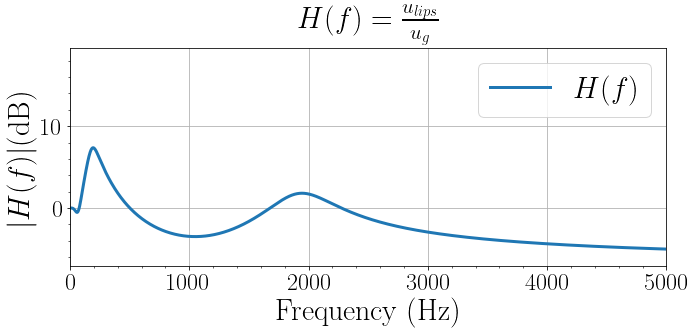

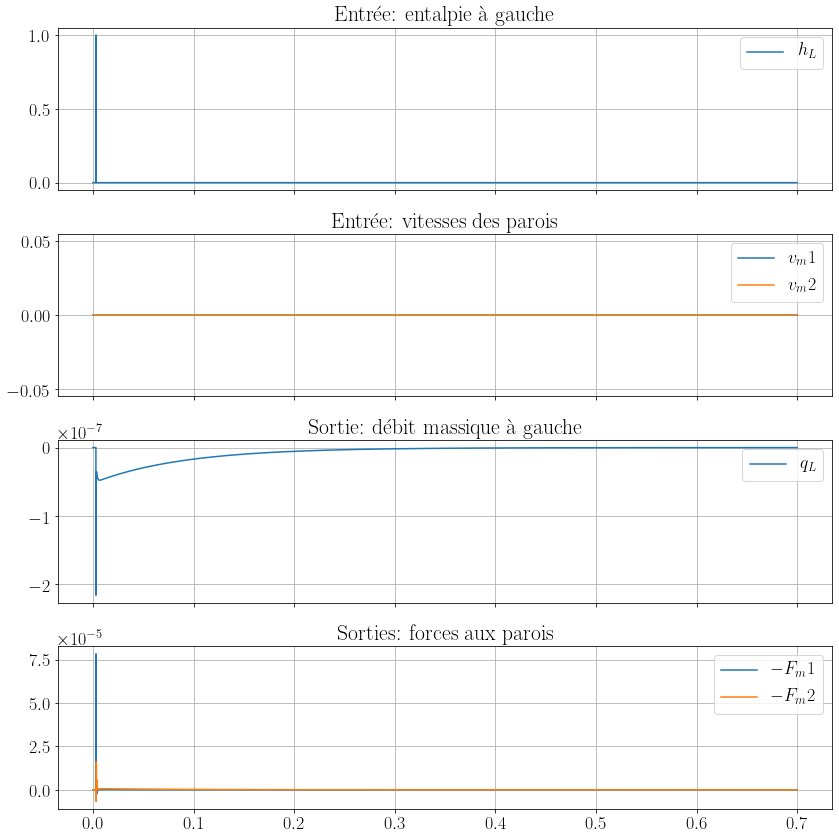

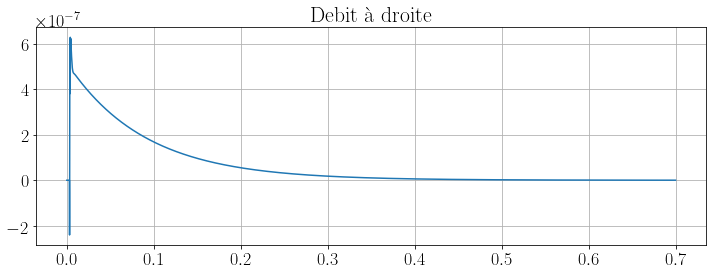

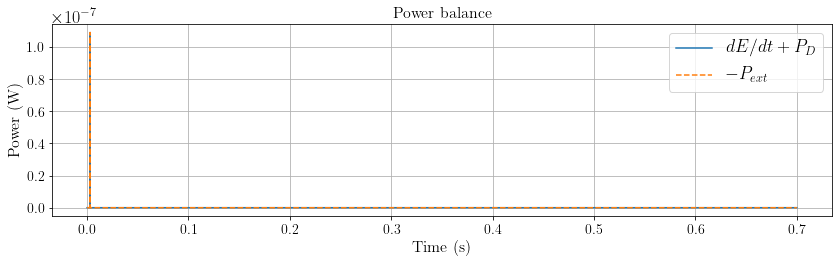

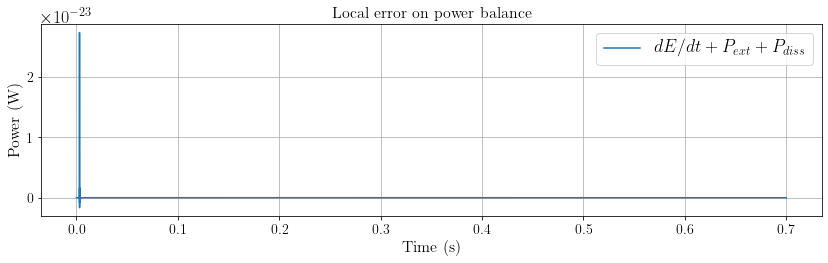

['q_L' '-F_m1' '-F_m2']
['v_k1' 'v_k2' 'q']
131072


<IPython.core.display.Javascript object>


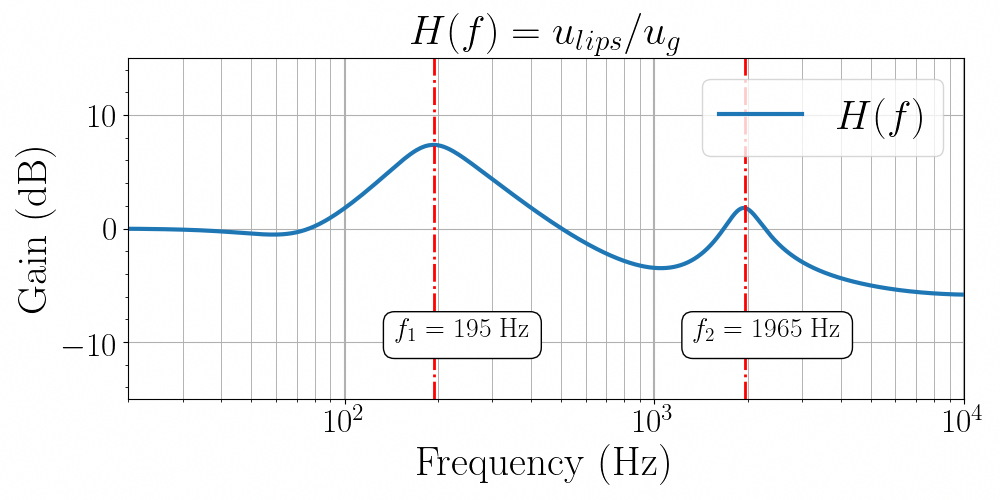

In [14]:
%run ./02b_GRAPHS_voyelle_i.ipynb